In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import sys ; sys.path.append("../")
from utils.pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
def pp(ds):
    return ds[['TLAI','GPP']]

In [12]:
path = '/glade/derecho/scratch/linnia/ctsm5.3.012.Nfix_transient_Nfix0001/run/*.h0.*'
files=sorted(glob.glob(path))

In [16]:
ds = xr.open_mfdataset(files[:-1])

In [20]:
path = '/glade/derecho/scratch/linnia/ctsm5.3.010_transient_test0000/run/*.h0.*'
files=sorted(glob.glob(path))
ds_default = xr.open_mfdataset(files,preprocess=pp)

### Plot difference

In [24]:
lai = amean(ds.TLAI.sel(time = slice('1985','2014'))).mean(dim='year')

In [25]:
lai_default = amean(ds_default.TLAI.sel(time = slice('1985','2014'))).mean(dim='year')

In [28]:
sgmap = xr.open_dataset('../utils/sgmap_retrain_h0.nc')
lai_map = get_map(lai,sgmap=sgmap)
lai_default_map = get_map(lai_default,sgmap=sgmap)

In [ ]:
ds_diff = (lai_map - lai_default_map)
ds_diff = ds_diff.assign_coords(lon=((ds_diff.lon + 180) % 360) - 180)
ds_diff = ds_diff.sortby('lon')  # Ensure longitudes are sorted

Text(0.5, 1.0, 'change in LAI \n ctsm5.3.012.Nfix - ctsm5.3.010')

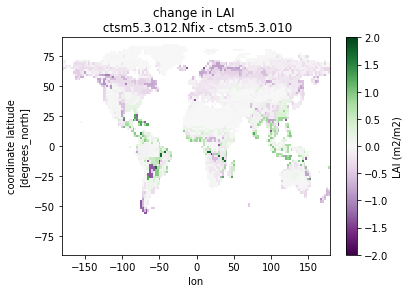

In [43]:
ds_diff.plot(vmin = -2,vmax=2,cmap='PRGn', cbar_kwargs={'label': 'LAI (m2/m2)'})
plt.title('change in LAI \n ctsm5.3.012.Nfix - ctsm5.3.010')

### 5.2, 5.3 and current paramfiles

In [7]:
def pp(ds):
    return ds[['TLAI','GPP']]

In [8]:
y1 = '2001'; y2 = '2023'

In [9]:
path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_lhc0000/run/*.h0.*'
files=sorted(glob.glob(path))
lhc0000 = xr.open_mfdataset(files, preprocess=pp)

In [60]:
lhc0000_lai = amean(lhc0000.TLAI.sel(time = slice(y1,y2))).mean(dim='year')
lhc0000_gpp = amean(lhc0000.GPP.sel(time = slice(y1,y2))).mean(dim='year')

In [11]:
path= '/glade/derecho/scratch/linnia/ctsm5.3.0_transient_oaat0101/run/*.h0.*'
files=sorted(glob.glob(path))
oaat530 = xr.open_mfdataset(files, preprocess=pp)

In [59]:
lai53 = amean(oaat530.TLAI.sel(time = slice(y1,y2))).mean(dim='year')
gpp53 = amean(oaat530.GPP.sel(time = slice(y1,y2))).mean(dim='year')

In [13]:
path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_test0005/run/*.h0.*'
files=sorted(glob.glob(path))
current = xr.open_mfdataset(files, preprocess=pp)

In [56]:
lai_current = amean(current.TLAI.sel(time = slice(y1,y2))).mean(dim='year')
gpp_current = amean(current.GPP.sel(time = slice(y1,y2))).mean(dim='year')

In [84]:
sgmap = xr.open_dataset('../utils/sgmap_retrain_h0.nc')
lai52_map = get_map(lhc0000_lai,sgmap=sgmap)
lai53_map = get_map(lai53,sgmap=sgmap)
current_map = get_map(lai_current,sgmap=sgmap)

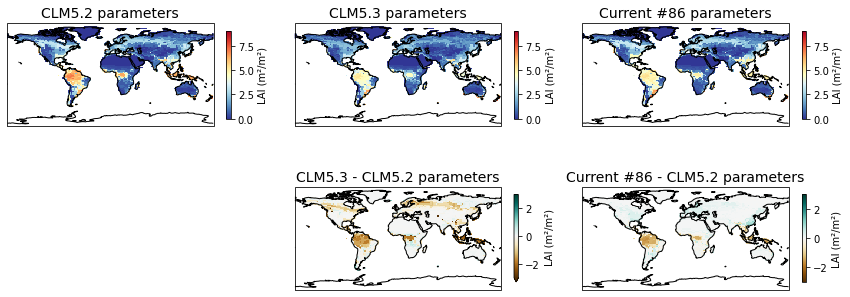

In [86]:
plt.figure(figsize=(12,5))

ax = plt.subplot(2,3,1,projection=ccrs.PlateCarree())
p = lai52_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.2 parameters', fontsize=14)

ax = plt.subplot(2,3,2,projection=ccrs.PlateCarree())
p = lai53_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.3 parameters', fontsize=14)

ax = plt.subplot(2,3,3,projection=ccrs.PlateCarree())
p = current_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('Current #86 parameters', fontsize=14)

diff = lai53_map - lai52_map
ax = plt.subplot(2,3,5,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.3 - CLM5.2 parameters', fontsize=14)

diff = current_map - lai52_map
ax = plt.subplot(2,3,6,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('Current #86 - CLM5.2 parameters', fontsize=14)
plt.tight_layout()
plt.savefig('lai_1850_rdbu.png',dpi=300)

### test0007

In [29]:
path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_test0007/run/*.h0.*'
files=sorted(glob.glob(path))
test7 = xr.open_mfdataset(files, preprocess=pp)

In [55]:
lai_test7 = amean(test7.TLAI.sel(time = slice(y1,y2))).mean(dim='year')
gpp_test7 = amean(test7.GPP.sel(time = slice(y1,y2))).mean(dim='year')

In [31]:
sgmap = xr.open_dataset('../utils/sgmap_retrain_h0.nc')
lai52_map = get_map(lhc0000_lai,sgmap=sgmap)
lai53_map = get_map(lai53,sgmap=sgmap)
current_map = get_map(lai_current,sgmap=sgmap)
test7_map = get_map(lai_test7,sgmap=sgmap)

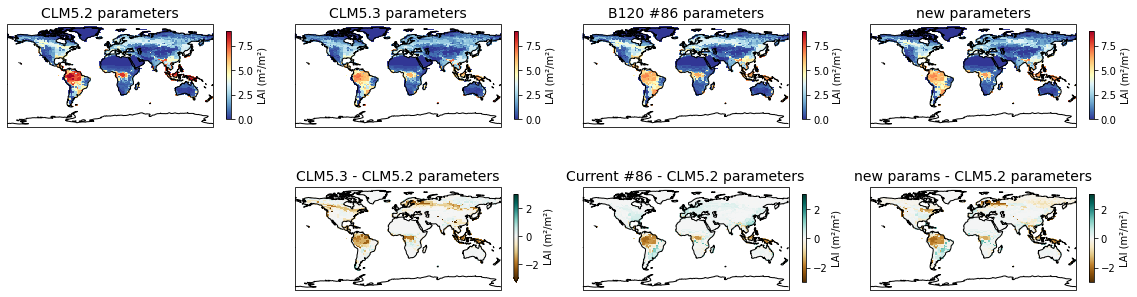

In [54]:
# map
plt.figure(figsize=(16,5))

ax = plt.subplot(2,4,1,projection=ccrs.PlateCarree())
p = lai52_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.2 parameters', fontsize=14)

ax = plt.subplot(2,4,2,projection=ccrs.PlateCarree())
p = lai53_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.3 parameters', fontsize=14)

ax = plt.subplot(2,4,3,projection=ccrs.PlateCarree())
p = current_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('B120 #86 parameters', fontsize=14)

ax = plt.subplot(2,4,4,projection=ccrs.PlateCarree())
p = test7_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=9,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('new parameters', fontsize=14)

diff = lai53_map - lai52_map
ax = plt.subplot(2,4,6,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.3 - CLM5.2 parameters', fontsize=14)

diff = current_map - lai52_map
ax = plt.subplot(2,4,7,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('Current #86 - CLM5.2 parameters', fontsize=14)

diff = test7_map - lai52_map
ax = plt.subplot(2,4,8,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'LAI (m²/m²)','shrink':0.5})
ax.coastlines()
ax.set_title('new params - CLM5.2 parameters', fontsize=14)


plt.tight_layout()
plt.savefig('lai_1850_test7.png',dpi=300)

In [61]:
sgmap = xr.open_dataset('../utils/sgmap_retrain_h0.nc')
gpp52_map = get_map(lhc0000_gpp,sgmap=sgmap)
gpp53_map = get_map(gpp53,sgmap=sgmap)
gppcurrent_map = get_map(gpp_current,sgmap=sgmap)
gpptest7_map = get_map(gpp_test7,sgmap=sgmap)

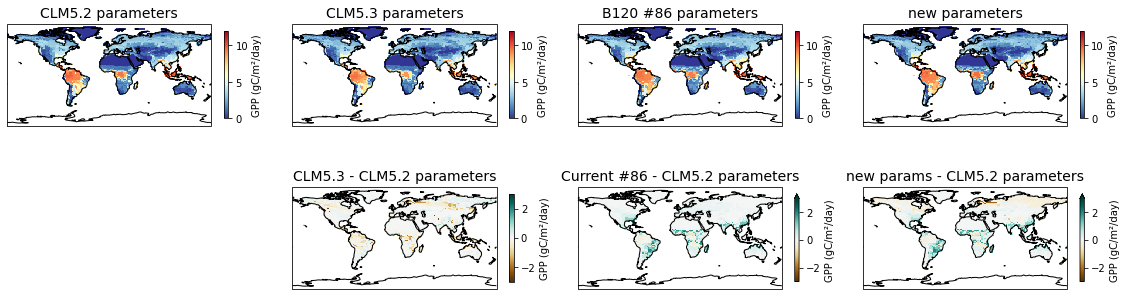

In [64]:
# map
plt.figure(figsize=(16,5))
cf = 60*60*24
ax = plt.subplot(2,4,1,projection=ccrs.PlateCarree())
p = (cf*gpp52_map).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=12,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.2 parameters', fontsize=14)

ax = plt.subplot(2,4,2,projection=ccrs.PlateCarree())
p = (cf*gpp53_map).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=12,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.3 parameters', fontsize=14)

ax = plt.subplot(2,4,3,projection=ccrs.PlateCarree())
p = (cf*gppcurrent_map).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=12,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('B120 #86 parameters', fontsize=14)

ax = plt.subplot(2,4,4,projection=ccrs.PlateCarree())
p = (cf*gpptest7_map).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=12,cmap='RdYlBu_r',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('new parameters', fontsize=14)

diff = cf*(gpp53_map - gpp52_map)
ax = plt.subplot(2,4,6,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('CLM5.3 - CLM5.2 parameters', fontsize=14)

diff = cf*(gppcurrent_map - gpp52_map)
ax = plt.subplot(2,4,7,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('Current #86 - CLM5.2 parameters', fontsize=14)

diff = cf*(gpptest7_map - gpp52_map)
ax = plt.subplot(2,4,8,projection=ccrs.PlateCarree())
p = diff.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-3,vmax=3,cmap='BrBG',
    cbar_kwargs={'label': 'GPP (gC/m²/day)','shrink':0.5})
ax.coastlines()
ax.set_title('new params - CLM5.2 parameters', fontsize=14)


plt.tight_layout()
plt.savefig('gpp_2001_test7.png',dpi=300)

In [ ]:
# timeseries

In [50]:
# Global mean time series GPP
la = xr.open_dataset('../utils/landarea_retrain_h0.nc').landarea
gpp_default = gmean(amean(lhc0000.GPP),la)
gpp_53 = gmean(amean(oaat530.GPP),la)
gpp_current = gmean(amean(current.GPP),la)
gpp_test7 = gmean(amean(test7.GPP),la)

In [51]:
# Global mean time series LAI
lai_default = gmean(amean(lhc0000.TLAI),la)
lai_53 = gmean(amean(oaat530.TLAI),la)
lai_current = gmean(amean(current.TLAI),la)
lai_test7 = gmean(amean(test7.TLAI),la)

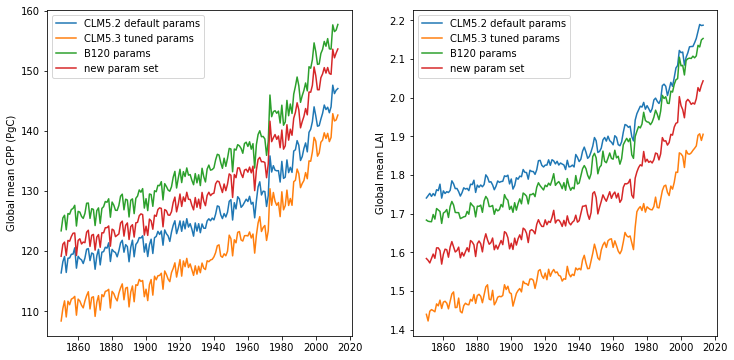

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(1850,2014),gpp_default[1:-10]*60*60*24*365*1E-9*la.sum(),label='CLM5.2 default params')
plt.plot(range(1850,2014),gpp_53[1:-10]*60*60*24*365*1E-9*la.sum(),label='CLM5.3 tuned params')
plt.plot(range(1850,2014),gpp_current[1:-10]*60*60*24*365*1E-9*la.sum(),label='B120 params')
plt.plot(range(1850,2014),gpp_test7[1:-10]*60*60*24*365*1E-9*la.sum(),label='new param set')
plt.legend()
plt.ylabel('Global mean GPP (PgC)')

plt.subplot(1,2,2)
plt.plot(range(1850,2014),lai_default[1:-10],label='CLM5.2 default params')
plt.plot(range(1850,2014),lai_53[1:-10],label='CLM5.3 tuned params')
plt.plot(range(1850,2014),lai_current[1:-10],label='B120 params')
plt.plot(range(1850,2014),lai_test7[1:-10],label='new param set')
plt.legend()
plt.ylabel('Global mean LAI')
plt.savefig('tests_gmean_timeseries_GPP_LAI_test7.png')